In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib as plt
df=pd.read_csv('/Data/train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
#Treat Missing values with Mean
#LoanAmount
df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


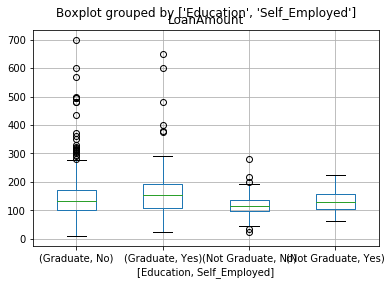

In [6]:
%matplotlib inline
df.boxplot(column='LoanAmount', by=['Education', 'Self_Employed'])
#Graduate,Not Self_Employed have little higher mean as well High Outliers 
#Graduate,Self_Employed have high Mean as well Outliers

In [7]:
#---- Treating Self_Employed Missing Values
df['Self_Employed'].value_counts()
#32 Missing values where more than 80% have "No", Replacing the others with "No" is a better option

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [8]:
df['Self_Employed'].fillna('No',inplace=True)

In [9]:
df['Self_Employed'].value_counts()

No     532
Yes     82
Name: Self_Employed, dtype: int64

In [10]:
#---- Treating LoanAmount Missing Values using 'Self_Employed and 'Education' column
treatlm = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Function to return value of this pivot_table
def fage(x):
 return treatlm.loc[x['Self_Employed'],x['Education']]
# Replace LoanAmount Missing value
#df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

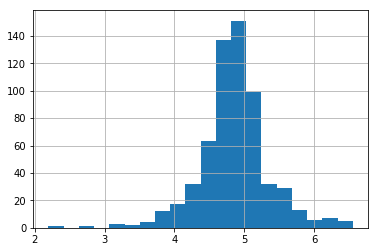

In [11]:
# Extreme values of LoanAmount 
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)
# Hence, we can see that there are not much extreme values only around 6%

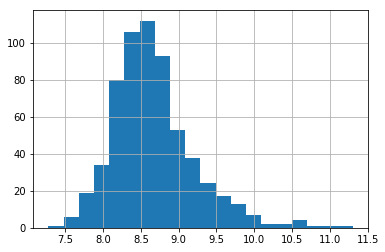

In [12]:
# ------Extreme values of ApplicantIncome---
# It is possible that ApplicantIncome with Higher LoanAmount can have higher(ApplicantIncome+CoaapplicantIncome)
df['TotalIncome']=df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log']=np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20)
#Hence, TotalIncome shows that the ApplicantIncome has less number of Outliers with even distribution

In [13]:
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [14]:
df['Loan_Status'].value_counts()


Y    422
N    192
Name: Loan_Status, dtype: int64

In [15]:
df['Gender']=df['Gender'].fillna(df['Gender'].dropna().mode().values[0])
df['Married']=df['Married'].fillna(df['Married'].dropna().mode().values[0])
df['Dependents']=df['Dependents'].fillna(df['Dependents'].dropna().mode().values[0])
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].dropna().mode().values[0])
df['Loan_Amount_Term']=df['Loan_Amount_Term'].fillna(df['Credit_History'].dropna().mode().values[0])

df['Gender']=df['Gender'].map({'Male':1,'Female':0}).astype(np.int)
df['Married']=df['Married'].map({'Yes':1,'No':0}).astype(np.int)
df['Dependents']=df['Dependents'].str.rstrip('+')
df['Dependents']=df['Dependents'].astype(np.int)
df['Education']= df['Education'].map({'Graduate':1,'Not Graduate':0}).astype(np.int)
df['Loan_Status']=df['Loan_Status'].map({'Y':1,'N':0}).astype(np.int)

In [16]:
 from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [17]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Logistic Regression

In [18]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s " % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [19]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946% 


In [20]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946% 


In [21]:
#We can try different combination of variables:
predictor_var = ['Credit_History','ApplicantIncome','CoapplicantIncome','Self_Employed','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 81.270%
Cross-Validation Score : 80.946% 


DecisionTree

In [22]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','ApplicantIncome','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 98.697%
Cross-Validation Score : 71.986% 


In [23]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 89.414%
Cross-Validation Score : 68.074% 


RandomForest

In [24]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 78.341% 


Feature Importance using RandomForest

In [25]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

TotalIncome_log     0.261701
Credit_History      0.259127
LoanAmount_log      0.232842
Property_Area       0.054337
Dependents          0.053121
Loan_Amount_Term    0.044713
Married             0.026391
Education           0.024319
Self_Employed       0.022430
Gender              0.021020
dtype: float64


In [26]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 83.388%
Cross-Validation Score : 80.786% 


In [37]:
model2 = RandomForestClassifier(n_estimators=25,criterion='entropy',  min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model2, df,predictor_var,outcome_var)

Accuracy : 82.899%
Cross-Validation Score : 80.948% 


/Applications/anaconda3


In [38]:
model2 = RandomForestClassifier(n_estimators =500, criterion='entropy', oob_score=True, random_state=1,n_jobs=-1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model2, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 78.828% 
